In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import sonar_touch
from sonar_touch.project import SonarTouchProject


In [2]:
project_path = os.path.join(os.path.dirname(sonar_touch.__file__), "..", "drafting_table")
if not os.path.exists(project_path):
    raise Exception(f"Project path {project_path} does not exist")

# from sonar_touch.models import AudioLocationNet1 as AudioLocationNet
from sonar_touch.models import AudioLocationNet2 as AudioLocationNet

model_file = os.path.join(project_path, f"model_{AudioLocationNet.__name__}.pth")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cpu


/home/luke/docs/sonar_touch/conda_env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
project = SonarTouchProject(project_path)

# Load the data
all_data = project.load_training_data()
np.random.shuffle(all_data)
all_input = np.stack([rec['data'] for rec in all_data], axis=0)
all_output = np.stack([rec['location'] for rec in all_data], axis=0)
input_tensor = torch.tensor(all_input, dtype=torch.float32).to(device)
output_tensor = torch.tensor(all_output, dtype=torch.float32).to(device)

n_val = 64
val_data, train_data = input_tensor[:n_val], input_tensor[n_val:]
val_labels, train_labels = output_tensor[:n_val], output_tensor[n_val:]

def batch_loader(data, labels, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            input = data[i:i+batch_size]
            input = input + np.random.normal(loc=0, scale=np.random.random() * 0.003, size=input.shape)
            # input *= 2**np.random.normal(loc=0, scale=1)
            # convert input tensor to float32 dtype
            input = torch.tensor(input, dtype=torch.float32).to(device)
            
            yield input, labels[i:i+batch_size]

batch_size = 32
train_loader = batch_loader(train_data, train_labels, batch_size)
val_loader = [val_data, val_labels]

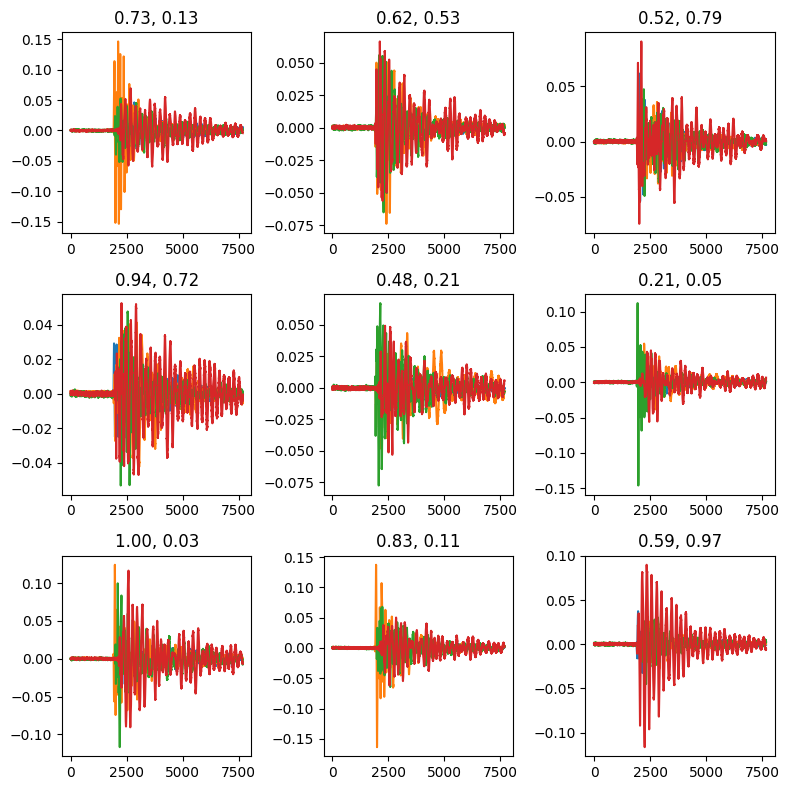

In [5]:
import matplotlib.pyplot as plt

n = 3
fig, ax = plt.subplots(n, n, figsize=(8, 8))
for i in range(n):
    for j in range(n):
        for ch in range(4):
            ax[i, j].plot(all_data[i*n+j]['data'][ch])
            loc = all_data[i*n+j]['location']
            ax[i, j].set_title(f"{loc[0]:.2f}, {loc[1]:.2f}")

fig.tight_layout()


In [6]:

# Initialize model, loss function, and optimizer
model = AudioLocationNet()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [7]:
class History:
    def __init__(self, name):
        self.name = name
        self.iter = []
        self.loss = []
        self.last_printed = 0

    def append(self, i, loss):
        self.iter.append(i)
        self.loss.append(loss)

    def print_recent(self):
        avg_loss = np.mean(self.loss[self.last_printed:])
        print(f"{self.iter[-1]:05d}: {self.name} loss: {avg_loss:.4f}")
        self.last_printed = len(self.loss)

    def plot(self, ax):
        ax.plot(self.iter, self.loss, label=self.name)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.legend()


In [8]:

def train_model(model, train_loader, val_loader, train_history, val_history, num_epochs=50):

    iter = 0
    for epoch in range(num_epochs):
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            # print(f"Epoch {epoch}, batch {i}, {inputs.shape}, {targets.shape}")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_history.append(iter, loss.item())

            if i % 10 == 9:
                train_history.print_recent()

            if i % 100 == 99:
                model.eval()
                with torch.no_grad():
                    outputs = model(val_loader[0])
                    loss = criterion(outputs, val_loader[1])
                    val_history.append(iter, loss.item())

                val_history.print_recent()

            iter += 1

    return train_history, val_history


/tmp/ipykernel_439946/2469748597.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  input = input + np.random.normal(loc=0, scale=np.random.random() * 0.003, size=input.shape)
/tmp/ipykernel_439946/2469748597.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32).to(device)


00009: Training loss: 0.1346
00019: Training loss: 0.0949
00029: Training loss: 0.0940
00039: Training loss: 0.0815
00049: Training loss: 0.0917
00059: Training loss: 0.0887
00069: Training loss: 0.0929
00079: Training loss: 0.0928
00089: Training loss: 0.0928
00099: Training loss: 0.0908
00099: Validation loss: 0.1000
00109: Training loss: 0.0882
00119: Training loss: 0.0884
00129: Training loss: 0.0933
00139: Training loss: 0.0916
00149: Training loss: 0.0933
00159: Training loss: 0.0838
00169: Training loss: 0.0967
00179: Training loss: 0.0914
00189: Training loss: 0.0856
00199: Training loss: 0.0864
00199: Validation loss: 0.1008
00209: Training loss: 0.0898
00219: Training loss: 0.0877
00229: Training loss: 0.0963
00239: Training loss: 0.0873
00249: Training loss: 0.0935
00259: Training loss: 0.0854
00269: Training loss: 0.0895
00279: Training loss: 0.0934
00289: Training loss: 0.0897
00299: Training loss: 0.0967
00299: Validation loss: 0.1007
00309: Training loss: 0.0826
00319: T

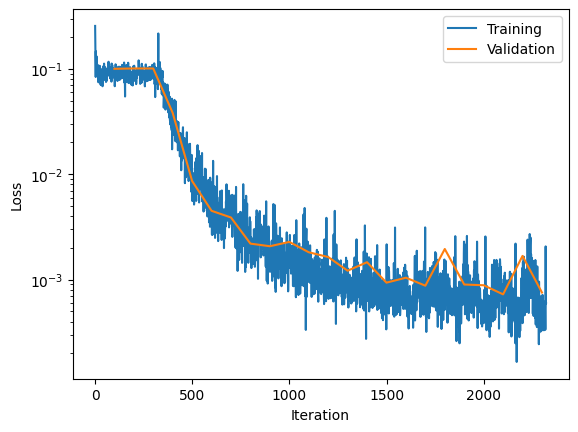

In [9]:
train_history = History("Training")
val_history = History("Validation")
try:
    train_losses, val_losses = train_model(model, train_loader, val_loader, train_history, val_history, num_epochs=10)
except KeyboardInterrupt:
    print(f"Training interrupted, saving to {model_file}")
    # save model
    model.save(model_file)
    # plot losses
    fig, ax = plt.subplots()
    train_history.plot(ax)
    val_history.plot(ax)
    ax.set_yscale('log')
    ax.legend()
    

In [10]:
# run model on all vaidation data
model.eval()
with torch.no_grad():
    val_outputs = model(val_loader[0])
    val_loss = criterion(val_outputs, val_loader[1])
    print(f"Validation loss: {val_loss.item():.4f}")

Validation loss: 0.0008


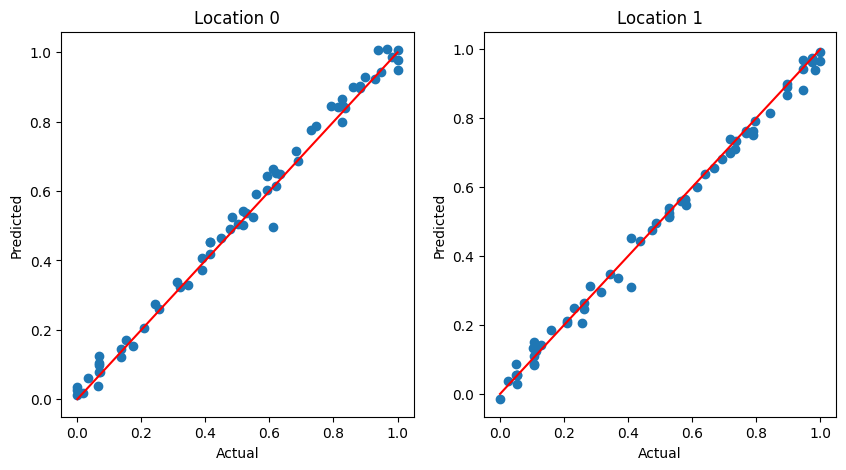

In [11]:
# plot the predicted vs actual locations
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # x, y
for i in range(2):
    ax[i].scatter(val_loader[1][:, i].cpu(), val_outputs[:, i].cpu())
    ax[i].plot([0, 1], [0, 1], color='red')
    ax[i].set_xlabel("Actual")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(f"Location {i}")